### 중복 불가 하니까 [1 에서 사용된 1이 1.에서는 사용 안되는 문제 발생

In [1]:
import cv2
import easyocr
import re
import glob
import os

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\a_kor_test\2015_G1_3_KOR\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_kor_test'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

def extract_sort_key(filename):
    # 파일명에서 left 또는 right 부분과 숫자 부분을 추출하여 정렬 키를 반환하는 함수
    match = re.match(r'.*_(left|right)__page(\d+)\.png', filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        return (number, prefix)  # 숫자를 먼저 비교하고, 그 다음에 left/right를 비교하여 정렬

    # 매칭되지 않는 경우는 마지막으로 처리
    return (float('inf'), filename)

# 파일을 정렬합니다.
sorted_files = sorted(png_files, key=extract_sort_key)

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

# 정규 표현식으로 매칭되는 패턴들 정의
pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
pattern2 = re.compile(r'^(?:\d{1,2}\s*<|\d{1,2}\s*윗글)')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b')

patterns = [pattern1, pattern2, pattern3]

# 모든 가능한 숫자 리스트 (1~45)
all_numbers = set(range(1, 46))

# 이미 사용된 숫자를 저장하는 집합
used_numbers_set = set()

# 각 이미지에 대해 처리
for idx, f_name in enumerate(sorted_files):
    # left_page0마다 숫자 리스트 리셋
    if 'left__page0' in f_name:
        all_numbers = set(range(1, 46))
    # 이미지 파일 읽기
    img = cv2.imread(f_name)

    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, patterns)

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # y 좌표로 정렬
        found_patterns.sort(key=lambda b: b[0][0][1])

        # 정렬된 결과 출력
        print("Sorted patterns by y-coordinate:")
        for pattern in found_patterns:
            print(pattern)

        # 첫 번째 패턴의 상단 y 좌표 구하기
        first_y_min = int(found_patterns[0][0][0][1])

        # 첫 번째 패턴이 y=50보다 큰 경우, 원본 이미지의 상단부터 첫 번째 패턴까지 자르기
        if first_y_min > 50:
            cropped_img = img[0:first_y_min:, :]

            # 결과 이미지 저장
            output_file = os.path.join(output_directory, f"{idx}_top_to_first.png")
            cv2.imwrite(output_file, cropped_img)

        # 패턴이 있는 텍스트의 내용과 위치 정보를 활용하여 처리
        for i, (bbox1, text1, _) in enumerate(found_patterns):
            if i < len(found_patterns) - 1:
                bbox2, text2, _ = found_patterns[i + 1]

                # 첫 번째 패턴의 상단과 두 번째 패턴의 상단 사이의 이미지 부분 자르기
                x_min = min(int(bbox1[0][0]), int(bbox2[0][0]))
                y_min = min(int(bbox1[0][1]), int(bbox2[0][1]))
                x_max = max(int(bbox1[2][0]), int(bbox2[2][0]))
                y_max = max(int(bbox1[0][1]), int(bbox2[0][1]))

                cropped_img = img[y_min:y_max, x_min:]

            # 결과 이미지 저장
            # output_file = os.path.join(output_directory, f"{idx}_{i}.png")
            # cv2.imwrite(output_file, cropped_img)

                # 결과 이미지 저장 (found_patterns에서 숫자 추출하여 파일명으로 사용)
                pattern_number = re.findall(r'\d+', text1)[0]  # found_patterns에서 숫자 추출
                if pattern_number:
                    pattern_number = int(pattern_number[0])
                    if pattern_number not in used_numbers_set:
                        # 결과 이미지 저장
                        output_file = os.path.join(output_directory, f"{idx}_{pattern_number}_{i}.png")
                        cv2.imwrite(output_file, cropped_img)

                        # 사용된 숫자 집합에 추가
                        used_numbers_set.add(pattern_number)

        # 마지막 패턴의 상단부터 원본 이미지의 끝까지 자르기
        last_bbox, last_text, _ = found_patterns[-1]
        x_min, y_min = int(last_bbox[0][0]), int(last_bbox[0][1])
        # y_min = int(last_bbox[0][1])
        cropped_img = img[y_min:-300, x_min:]

        # 패턴에서 숫자 추출
        pattern_numbers = re.findall(r'\d+', last_text) # found_patterns에서 숫자 추출
        if pattern_numbers:
            pattern_number = int(pattern_numbers[0])
            if pattern_number not in used_numbers_set:
                # 결과 이미지 저장
                output_file = os.path.join(output_directory, f"{idx}_{pattern_number}_{i}.png")
                cv2.imwrite(output_file, cropped_img)
                
                # 사용된 숫자 집합에 추가
                used_numbers_set.add(pattern_number)

    else:
        # 패턴이 발견되지 않으면 전체 이미지를 저장
        height, width, _ = img.shape
        cropped_img = img[0:height, 0:width]

        # 결과 이미지 저장 (파일명을 임의로 지정)
        output_file = os.path.join(output_directory, f"whole_image_{idx}.png")
        cv2.imwrite(output_file, cropped_img)
        
    # 현재까지 사용된 숫자 리스트 출력
    print("Used numbers so far:", sorted(used_numbers_set))
    print("Remaining numbers:", sorted(all_numbers))

# 모든 이미지 처리 완료 후에 남은 숫자 리스트 출력 및 파일로 저장
remaining_numbers = sorted(all_numbers - used_numbers_set)
print("Remaining numbers list:", remaining_numbers)

# 결과 텍스트 파일에 남은 숫자 리스트 저장
result_filename = "remaining_numbers.txt"
result_filepath = os.path.join(output_directory, result_filename)

with open(result_filepath, 'w') as f:
    for num in remaining_numbers:
        f.write(f"{num}\n")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


KeyboardInterrupt: 

# 국어 코드

In [1]:
import cv2, easyocr, re, glob, os, logging

# 로그 설정
LOG_FILE = "process.log"
MAX_LOG_LINES = 1000  # 최대 로그 라인 수

def setup_logger():
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    handler = logging.FileHandler(LOG_FILE, mode='w')
    handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
    logger.addHandler(handler)
    return logger

def check_log_size(logger):
    if os.path.exists(LOG_FILE) and sum(1 for line in open(LOG_FILE)) > MAX_LOG_LINES:
        logger.handlers[0].stream.close()
        os.remove(LOG_FILE)
        setup_logger()

logger = setup_logger()

# 이미지 파일들이 있는 디렉토리 경로
base_directory = r"D:\final_project\data\KOR\kor_preprocess\KOR3"


# 폴더 순회 및 작업
for year_folder in os.listdir(base_directory):
    if year_folder.startswith('KOR_G1') or year_folder.startswith('KOR_G2') or year_folder.startswith('KOR_G3'):
        cropped_directory = os.path.join(base_directory, year_folder, 'cropped')
        output_directory = os.path.join(base_directory, year_folder, 'fix_crop')

# # 폴더 순회 및 작업
# for year_folder in os.listdir(base_directory):
#     if year_folder.startswith('KOR_G2_'):
#         cropped_directory = os.path.join(base_directory, year_folder, 'cropped')
#         output_directory = os.path.join(base_directory, year_folder, 'fix_crop')

        # 결과 디렉토리가 없으면 생성
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        # 해당 디렉토리 내의 모든 png 파일 찾기
        png_files = glob.glob(os.path.join(cropped_directory, '*.png'))

        def extract_sort_key(filename):
            match = re.match(r'.*_(left|right)_KOR_page(\d+)\.png', filename)
            if match:
                prefix = match.group(1)
                number = int(match.group(2))
                return (number, prefix)
            return (float('inf'), filename)

        # 파일을 정렬합니다.
        sorted_files = sorted(png_files, key=extract_sort_key)

        # EasyOCR을 사용하여 텍스트 인식
        reader = easyocr.Reader(['ko', 'en'])

        # 정규 표현식으로 매칭되는 패턴들 정의
        pattern1 = re.compile(r"\b(?:[1-9]\.|[1-3][0-9]\.|4[0-5]\.\s*)(?!\d)")
        pattern2 = re.compile(r'^(?:\d{1,2}\s*<|\d{1,2}\s*윗글)')
        pattern3 = re.compile(r'\[(\d+\s*~\s*\d+)\]|\[\d+\s*\b')

        patterns = [pattern1, pattern2, pattern3]

        # 각 이미지에 대해 처리
        for idx, f_name in enumerate(sorted_files):
            # 이미지 파일 읽기 전에 경로 확인
            if not os.path.exists(f_name):
                print(f"File does not exist: {f_name}")
                continue

            # 이미지 파일 읽기
            img = cv2.imread(f_name)

            # 이미지가 제대로 로드되었는지 확인
            if img is None:
                print(f"Failed to load image: {f_name}")
                continue

            # EasyOCR을 사용하여 텍스트 인식
            results = reader.readtext(f_name)

            # 정규 표현식으로 매칭되는 패턴 찾기
            def find_patterns(results, patterns):
                found_patterns = []
                for pattern in patterns:
                    for (bbox, text, prob) in results:
                        if re.match(pattern, text):
                            found_patterns.append((bbox, text, prob))
                return found_patterns

            # 패턴 찾기
            found_patterns = find_patterns(results, patterns)

            if found_patterns:
                found_patterns.sort(key=lambda b: b[0][0][1])

                first_y_min = int(found_patterns[0][0][0][1])

                if first_y_min > 50:
                    cropped_img = img[0:first_y_min, :]
                    output_file = os.path.join(output_directory, f"{idx}_top_to_first.png").replace("\\", "/")
                    if cropped_img.size > 0:
                        cv2.imwrite(output_file, cropped_img)
                        print(f"Saved cropped image to {output_file}")
                    else:
                        print(f"Cropped image is empty for file: {f_name}")

                for i, (bbox1, text1, _) in enumerate(found_patterns):
                    if i < len(found_patterns) - 1:
                        bbox2, text2, _ = found_patterns[i + 1]

                        x_min = min(int(bbox1[0][0]), int(bbox2[0][0]))
                        y_min = min(int(bbox1[0][1]), int(bbox2[0][1]))
                        x_max = max(int(bbox1[2][0]), int(bbox2[2][0]))
                        y_max = max(int(bbox1[0][1]), int(bbox2[0][1]))

                        # print(f"Cropping coordinates for file {f_name} between pattern {i} and {i+1}: (x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max})")

                        if y_max > y_min:
                            cropped_img = img[y_min:y_max, x_min:]
                            pattern_number = re.findall(r'\d+', text1)[0]
                            output_file = os.path.join(output_directory, f"{idx}_{pattern_number}_{i}.png").replace("\\", "/")
                            if cropped_img.size > 0:
                                cv2.imwrite(output_file, cropped_img)
                                print(f"Saved cropped image to {output_file}")
                            else:
                                print(f"Cropped image is empty for file: {f_name} between pattern {i} and {i+1}")
                        else:
                            print(f"Invalid crop region for file: {f_name} between pattern {i} and {i+1}")

                last_bbox, last_text, _ = found_patterns[-1]
                x_min, y_min = int(last_bbox[0][0]), int(last_bbox[0][1])
                # print(f"Cropping coordinates for file {f_name} after last pattern: (x_min={x_min}, y_min={y_min})")
                cropped_img = img[y_min:, x_min:]

                if cropped_img.size > 0:
                    last_pattern_number = re.findall(r'\d+', last_text)[0]
                    output_file = os.path.join(output_directory, f"{idx}_{last_pattern_number}_last.png").replace("\\", "/")
                    cv2.imwrite(output_file, cropped_img)
                    print(f"Saved cropped image to {output_file}")
                else:
                    print(f"Cropped image is empty for file: {f_name} after last pattern")

            else:
                height, width, _ = img.shape
                cropped_img = img[0:height, 0:width]
                output_file = os.path.join(output_directory, f"{idx}_whole_image.png").replace("\\", "/")
                if cropped_img.size > 0:
                    cv2.imwrite(output_file, cropped_img)
                    print(f"Saved cropped image to {output_file}")
                else:
                    print(f"Whole image is empty for file: {f_name}")


c:\Users\BIG3-06\.conda\envs\newa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saved cropped image to D:/final_project/data/KOR/kor_preprocess/KOR3/KOR_G3_2022_06_language_media/fix_crop/0_1_0.png
Saved cropped image to D:/final_project/data/KOR/kor_preprocess/KOR3/KOR_G3_2022_06_language_media/fix_crop/0_1_last.png
Saved cropped image to D:/final_project/data/KOR/kor_preprocess/KOR3/KOR_G3_2022_06_language_media/fix_crop/1_whole_image.png
Saved cropped image to D:/final_project/data/KOR/kor_preprocess/KOR3/KOR_G3_2022_06_language_media/fix_crop/2_4_last.png
Saved cropped image to D:/final_project/data/KOR/kor_preprocess/KOR3/KOR_G3_2022_06_language_media/fix_crop/3_top_to_first.png
Saved cropped image to D:/final_project/data/KOR/kor_preprocess/KOR3/KOR_G3_2022_06_language_media/fix_crop/3_4_last.png
Saved cropped image to D:/final_project/data/KOR/kor_preprocess/KOR3/KOR_G3_2022_06_language_media/fix_crop/4_whole_image.png
Saved cropped image to D:/final_project/data/KOR/kor_preprocess/KOR3/KOR_G3_2022_06_language_media/fix_crop/5_whole_image.png
Saved cropped 

# 정규식으로 잘 찾는지 확인하는 코드

In [13]:
import cv2
import easyocr
import re
import glob
import os

# 이미지 파일들이 있는 디렉토리 경로
directory = r'C:\Users\hana9\preprocessing\KOR_lr\2018_G1_3_KOR\cropped'

# 결과 이미지를 저장할 디렉토리 경로
output_directory = r'C:\Users\hana9\preprocessing\output_images_kor_test'

# 해당 디렉토리 내의 모든 png 파일 찾기
png_files = glob.glob(os.path.join(directory, '*.png'))

# EasyOCR을 사용하여 텍스트 인식
reader = easyocr.Reader(['ko', 'en'])

def extract_sort_key(filename):
    # 파일명에서 left 또는 right 부분과 숫자 부분을 추출하여 정렬 키를 반환하는 함수
    match = re.match(r'.*_(left|right)_kor_page(\d+)\.png', filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        return (number, prefix)  # 숫자를 먼저 비교하고, 그 다음에 left/right를 비교하여 정렬

    # 매칭되지 않는 경우는 마지막으로 처리
    return (float('inf'), filename)

# 파일을 정렬합니다.
sorted_files = sorted(png_files, key=extract_sort_key)

# 정규 표현식으로 매칭되는 패턴들 정의
# pattern1 = re.compile(r"\b([0-9]|[1-3][0-9]|4[0-5])\.\s*")
# pattern2 = re.compile(r'^(?:\d{1,2}\s*<|\d{1,2}\s*윗글)')
# pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[\d+\s*\b')

pattern1 = re.compile(r"\b(?:[1-9]\.|[1-3][0-9]\.|4[0-5]\.\s*)(?!\d)")
pattern2 = re.compile(r'^(?:\d{1,2}\s*<|\d{1,2}\s*윗글)')
pattern3 = re.compile(r'\[(\d+)\s*~\s*(\d+)\]|\[(?!\d+\]).*?\[\d+')

patterns = [pattern1, pattern2, pattern3]

# 각 이미지에 대해 처리
for idx, f_name in enumerate(sorted_files):
    # 이미지 파일 읽기
    img = cv2.imread(f_name)

    # EasyOCR을 사용하여 텍스트 인식
    results = reader.readtext(f_name)

    # 정규 표현식으로 매칭되는 패턴 찾기
    def find_patterns(results, patterns):
        found_patterns = []
        for pattern in patterns:
            for (bbox, text, prob) in results:
                if re.match(pattern, text):
                    found_patterns.append((bbox, text, prob))
        return found_patterns

    # 패턴 찾기
    found_patterns = find_patterns(results, patterns)

    if found_patterns:
        # 패턴 출력 (디버깅용)
        print("Found patterns:", found_patterns)

        # 패턴이 있는 텍스트의 내용과 위치 정보를 활용하여 처리
        for (bbox, text, prob) in found_patterns:
            print(f"Pattern found at bbox {bbox}: {text}")

    # 추가적인 처리나 저장 코드를 여기에 추가할 수 있습니다.


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Found patterns: [([[175, 1497], [195, 1497], [195, 1523], [175, 1523]], '1.', 0.999418591594539), ([[170, 12], [248, 12], [248, 44], [170, 44]], '[1 ~3]', 0.9769924456589025)]
Pattern found at bbox [[175, 1497], [195, 1497], [195, 1523], [175, 1523]]: 1.
Pattern found at bbox [[170, 12], [248, 12], [248, 44], [170, 44]]: [1 ~3]
Found patterns: [([[12, 1046], [270, 1046], [270, 1078], [12, 1078]], '3. 위   강연올 들은   학생이', 0.5700617706736055)]
Pattern found at bbox [[12, 1046], [270, 1046], [270, 1078], [12, 1078]]: 3. 위   강연올 들은   학생이
Found patterns: [([[170, 14], [248, 14], [248, 42], [170, 42]], '[4 ~ 7]', 0.4906726155250976)]
Pattern found at bbox [[170, 14], [248, 14], [248, 42], [170, 42]]: [4 ~ 7]
Found patterns: [([[12, 1416], [630, 1416], [630, 1448], [12, 1448]], '4. (가)의  대답   참여자의  말하기   방식으로  적절하지 앞은 것은?', 0.3454395993546366)]
Pattern found at bbox [[12, 1416], [630, 1416], [630, 1448], [12, 1448]]: 4. (가)의  대답   참여자의  말하기   방식으로  적절하지 앞은 것은?
Found patterns: [([[172, 16], [810

KeyboardInterrupt: 

# 영역 확인 코드

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[170, 12], [248, 12], [248, 44], [170, 44]], '[1 ~3]', 0.9769924456589025),
 ([[258, 12], [328, 12], [328, 44], [258, 44]], '다음은', 0.9998106634086571),
 ([[340, 10], [595, 10], [595, 46], [340, 46]],
  "세마포르' 에 대한  강연의",
  0.7298947114433257),
 ([[604, 14], [778, 14], [778, 44], [604, 44]],
  '일부이다 . 물음에',
  0.9151417482840102),
 ([[787, 15], [807, 15], [807, 39], [787, 39]], '답', 0.9996291742845109),
 ([[190, 48], [262, 48], [262, 76], [190, 76]], '하시오', 0.9982518990964793),
 ([[210, 100], [280, 100], [280, 132], [210, 132]], '여러분', 0.9992883781025189),
 ([[290, 102], [412, 102], [412, 132], [290, 132]],
  '과거에논   먼',
  0.4724935423318545),
 ([[422, 102], [488, 102], [488, 132], [422, 132]], '곳까지', 0.9853772809165697),
 ([[498, 102], [792, 102], [792, 132], [498, 132]],
  '메시지름   전날하기   위해   어떤',
  0.464914124893818),
 ([[192, 134], [792, 134], [792, 166], [192, 166]],
  '시각   통신   수단올   사용햇올까요?   (청중의   대답을 들은 후 고',
  0.5549591256967733),
 ([[192, 166], [790, 166], [790, 198], [19

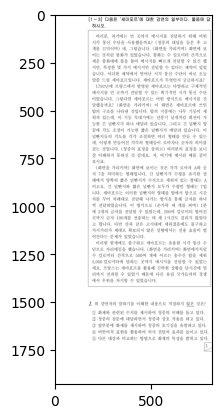

In [15]:
from matplotlib.pyplot import imshow
from PIL import Image

f_name = r'C:\Users\hana9\preprocessing\KOR_lr\2018_G1_3_KOR\cropped\2018_G1_3_KOR_left_kor_page0.png'

%matplotlib inline
pil_im = Image.open(f_name, 'r')
imshow(pil_im)

import easyocr

# easy-ocr
reader = easyocr.Reader(['ko','en'])
txt = reader.readtext(f_name)
txt

In [18]:
# PNG img to OCR txt
## GPU 있을시 자동으로 GPU 동작

import easyocr

reader = easyocr.Reader(['ko','en'])
ocr_txt = reader.readtext(r"C:\Users\hana9\preprocessing\output_images_kor_test3\17_25_0.png")

# bounding box, text, confident level.
for b_box, text, cf_level in ocr_txt:
    print(b_box, text, cf_level)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[[2, 4], [532, 4], [532, 36], [2, 36]] 25. 윗글의 서술상  특징에   대한   설명으로 적절한 것은? 0.3280776955878851
[[48, 52], [640, 52], [640, 84], [48, 84]] 장면마다   다른  서술자루   설정하여   사건을  다각도로   제시하고 0.3839251637007293
[[50, 86], [102, 86], [102, 116], [50, 116]] 있다 0.9998630254901355
[[48, 118], [562, 118], [562, 150], [48, 150]] 사건올   체험한   서술자가   중심인물과   관련된   자신의 0.6329993066755378
[[572, 120], [640, 120], [640, 150], [572, 150]] 생각울 0.7450660357037219
[[50, 154], [194, 154], [194, 184], [50, 184]] 드러내고 있다. 0.7042836354602867
[[50, 187], [214, 187], [214, 218], [50, 218]] 외부   이야기에서 0.9775352964235912
[[224, 188], [562, 188], [562, 218], [224, 218]] 내부   이야기로   장면을   전환하면서 0.7145529545711478
[[572, 188], [640, 188], [640, 218], [572, 218]] 사건을 0.3814390238925198
[[50, 220], [192, 220], [192, 252], [50, 252]] 전개하고 있다. 0.7402810503972073
[[50, 254], [640, 254], [640, 286], [50, 286]] 작품   밖의   서술자가   중심인물의   내적   갈등이   해소되논   과정 0.5784091703307963
[[52, 288], [226, 288], [226, 320], [52, 320]] 올 서술하고  있

In [17]:
import os
from pdf2image import convert_from_path
import easyocr

# PDF 파일 경로
pdf_path = r"D:\final_project\data\KOR\kor_pdf\G1\KOR_G1_2018_03.pdf"

# PDF를 이미지로 변환 (추천 DPI: 300)
images = convert_from_path(pdf_path, dpi=1000)

# EasyOCR 리더 생성 (한국어를 지원하도록 설정)
reader = easyocr.Reader(['ko', 'en'])  # 한국어와 영어 지원

# 텍스트를 저장할 파일 경로
output_text_path = r"D:\final_project\data\KOR\kor_crop\KOR_G1_2017_09\cropped\extracted_text.txt"

# 텍스트 파일 열기 (쓰기 모드)
with open(output_text_path, 'w', encoding='utf-8') as f:
    # 각 페이지의 이미지를 저장하고 텍스트 추출
    for i, image in enumerate(images):
        # 이미지 파일 경로
        image_path = f"page_{i+1}.png"
        image.save(image_path, 'PNG')
        
        # 이미지에서 텍스트 추출
        result = reader.readtext(image_path)
        
        # 추출된 텍스트 파일에 쓰기
        f.write(f"Page {i + 1}:\n")
        for (bbox, text, prob) in result:
            f.write(text + "\n")
        f.write("\n\n")
        
        # 콘솔에 추출된 텍스트 출력 (선택 사항)
        print(f"Page {i + 1}:")
        for (bbox, text, prob) in result:
            print(text)
        print("\n")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Page 1:
2018학년도 3월 고1 전국연합학력평가 문제지
제 1 교시
국어 영역
1
[1 ~3] 다음은
세마포르' 에
대한
강연의
일부이다 . 물음에 답
2. 위 강연에서   제시햇올 시각 자료로 적절하지 않은 것은?
하시오.
여러분,
과거에는   먼   곳까지
메시지률
전달하기
위해   어떤
불을 이용한 봉화
세마포르 탑의 구조
시각   통신   수단올   사용햇올까요?   (청중의   대답올 들은 후 고
장점
짧은 널반지
개틀 끄덕이며)   네;  그렇습니다.  (화면올 가리키며)   화면에 보
빠른
메시지 전달
긴 널빠지
단점
-나무 기둥
이논 것처럼 봉화가 있있습니다. 봉화는 수 킬로미터   간격으로
메시지만 전달
세운 봉화대에   불을 붙여   메시지률 빠르게   전달할 수 잇긴 햇
지만   특정한 몇 가지   메시지만   전달할 수 있다는   제약이  없
습니다   이러한   제약에서
벗어난   시각   통신   수단이
바로 오늘
말씀 드럭   세마포르입니다.  세마프로가 무엇인지 궁금하시조?
글자루 나타내는 방식
세마포르트 대체한 모스 부호
1792년에  프랑스에서  발명원   세마포르는  다양하고 구체적인
Ao-
B
무
메시지틀
먼
곳가지   전달할  수 있는   희기적인   시각  통신  수단
C
이/습니다 .  그렇다면   세마포르는   어떤   방식으로   메시지루   전
D
달햇올까요?   (화면올   가리키터)
이
화면은
세마프르에
쓰인
탑의
구조v   나타님   것입니다:  탑의
지붕에는   나무 기둥이  세
위저  있는데, 이 기둥  꼭대기에는   선풍기   날개처럼   회전이 가
능한  긴 널빠지가 하나  매달려  있습니다: 그리고 긴 널빠지 양
프랑스의 세마프르 통신망
송수신 탑 :
끝에
각도   조절이   가능하   짧은  널빠지가   매달려   있습니다   이
500여 개
널반지들의
각도트   각각  조절하면   여러   형태률
만들   수 있는
통신 선로
데; 이렇게  만들어진  각각의   형태들이   로마자나  숫자의

KeyboardInterrupt: 